In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'EURUSD'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,slope_3,slope_4,slope_5,slope_10,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
29,11/2/2000,0.9852,0.9880,0.9787,0.9870,0.0,-182.288029,-107.547908,110.180352,267.659617,...,-1.408451,-1.986097,-1.575588,0.989968,-0.008951,-18.604988,0.99210,0.98095,0.986525,0.98335
30,14/2/2000,0.9870,0.9915,0.9775,0.9782,1.0,-138.806852,-232.694564,-163.570730,243.455671,...,-2.238657,-2.287484,-2.859980,0.988890,-0.009095,-29.003535,0.98975,0.97810,0.983925,0.98450
31,15/2/2000,0.9782,0.9864,0.9764,0.9816,1.0,-117.589417,-229.011008,-290.630887,82.508251,...,-0.677932,-1.898861,-1.947857,0.987967,-0.008934,-28.932141,0.98895,0.97695,0.982950,0.98140
32,16/2/2000,0.9816,0.9873,0.9791,0.9865,1.0,-283.400810,-240.963855,-299.068878,-241.600482,...,0.941369,-0.182131,-1.409155,0.987577,-0.008434,22.823606,0.98685,0.97775,0.982300,0.98320
33,17/2/2000,0.9865,0.9952,0.9842,0.9881,0.0,187.686620,121.212121,192.351211,-27.659384,...,1.750592,1.105085,-0.020237,0.987742,-0.007860,102.152374,0.99125,0.98165,0.986450,0.98970


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)

In [7]:
df.head()

,date,high,open,low,close,slope_3,slope_4,slope_5,slope_10,slope_20,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
29,11/2/2000,0.9880,0.9852,0.9787,0.9870,-182.288029,-107.547908,110.180352,267.659617,-332.418693,...,-1.408451,-1.986097,-1.575588,0.989968,-0.008951,-18.604988,0.99210,0.98095,0.986525,0.98335
30,14/2/2000,0.9915,0.9870,0.9775,0.9782,-138.806852,-232.694564,-163.570730,243.455671,-326.011450,...,-2.238657,-2.287484,-2.859980,0.988890,-0.009095,-29.003535,0.98975,0.97810,0.983925,0.98450
31,15/2/2000,0.9864,0.9782,0.9764,0.9816,-117.589417,-229.011008,-290.630887,82.508251,-324.186875,...,-0.677932,-1.898861,-1.947857,0.987967,-0.008934,-28.932141,0.98895,0.97695,0.982950,0.98140
32,16/2/2000,0.9873,0.9816,0.9791,0.9865,-283.400810,-240.963855,-299.068878,-241.600482,-321.825656,...,0.941369,-0.182131,-1.409155,0.987577,-0.008434,22.823606,0.98685,0.97775,0.982300,0.98320
33,17/2/2000,0.9952,0.9865,0.9842,0.9881,187.686620,121.212121,192.351211,-27.659384,-293.587579,...,1.750592,1.105085,-0.020237,0.987742,-0.007860,102.152374,0.99125,0.98165,0.986450,0.98970


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 10% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.20171117, 0.20520456, 0.20390257, ..., 0.20623769, 0.20549605,
        0.2028013 ],
       [0.20624838, 0.20753496, 0.20233106, ..., 0.20249508, 0.20208968,
        0.20429967],
       [0.19963702, 0.1961419 , 0.20089052, ..., 0.2009849 , 0.20081229,
        0.20026059],
       ...,
       [0.35195748, 0.35512688, 0.36367208, ..., 0.36250821, 0.35632636,
        0.35778502],
       [0.35934664, 0.35797514, 0.36498167, ..., 0.3641497 , 0.35937244,
        0.36214984],
       [0.35934664, 0.36470741, 0.36746988, ..., 0.36605384, 0.36218925,
        0.36338762]])

In [10]:
input_data.shape

(5212, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.20171117, 0.20520456, 0.20390257, ..., 0.20623769, 0.20549605,
        0.2028013 ],
       [0.20624838, 0.20753496, 0.20233106, ..., 0.20249508, 0.20208968,
        0.20429967],
       [0.19963702, 0.1961419 , 0.20089052, ..., 0.2009849 , 0.20081229,
        0.20026059],
       ...,
       [0.35195748, 0.35512688, 0.36367208, ..., 0.36250821, 0.35632636,
        0.35778502],
       [0.35934664, 0.35797514, 0.36498167, ..., 0.3641497 , 0.35937244,
        0.36214984],
       [0.35934664, 0.36470741, 0.36746988, ..., 0.36605384, 0.36218925,
        0.36338762]])

In [13]:
input_data[[0],1:]

array([[0.20520456, 0.20390257, 0.20753496, 0.7408856 , 0.76568859,
        0.7184918 , 0.62832074, 0.45903475, 0.34342616, 0.20346278,
        0.4986871 , 0.45091246, 0.49028242, 0.55385229, 0.57852838,
        0.58445968, 0.49612087, 0.52413284, 0.55385229, 0.57852838,
        0.58445968, 0.30543164, 0.32290487, 0.3211578 , 0.33097886,
        0.19588276, 0.46079171, 0.5040482 , 0.2045974 , 0.20623769,
        0.20549605, 0.2028013 ]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.20520456, 0.20390257, 0.20753496, ..., 0.20623769,
          0.20549605, 0.2028013 ]],

        [[0.20753496, 0.20233106, 0.1961419 , ..., 0.20249508,
          0.20208968, 0.20429967]],

        [[0.1961419 , 0.20089052, 0.20054376, ..., 0.2009849 ,
          0.20081229, 0.20026059]],

        ...,

        [[0.16235111, 0.15872184, 0.15277059, ..., 0.16290217,
          0.16281812, 0.15739414]],

        [[0.15277059, 0.14824515, 0.14746245, ..., 0.15272489,
          0.1516819 , 0.14944625]],

        [[0.14746245, 0.14719749, 0.14409632, ..., 0.14694682,
          0.14536045, 0.14482085]]],


       [[[0.20753496, 0.20233106, 0.1961419 , ..., 0.20249508,
          0.20208968, 0.20429967]],

        [[0.1961419 , 0.20089052, 0.20054376, ..., 0.2009849 ,
          0.20081229, 0.20026059]],

        [[0.20054376, 0.2044264 , 0.20688762, ..., 0.20203546,
          0.1999607 , 0.20260586]],

        ...,

        [[0.15277059, 0.14824515, 0.14746245, ..., 0.15272489,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4646, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([1.2371, 1.2465, 1.251 , 1.2555, 1.2435, 1.2412, 1.236 , 1.2352,
       1.2337, 1.2355, 1.2346, 1.2242, 1.2273, 1.2336, 1.2365, 1.242 ,
       1.2444, 1.2446, 1.2334, 1.2345, 1.2407, 1.2413, 1.2384, 1.2336,
       1.2359, 1.2355, 1.235 , 1.2388, 1.2373, 1.2462, 1.2476, 1.2422,
       1.2335, 1.2331, 1.2345, 1.2336, 1.2315, 1.229 , 1.2291, 1.233 ,
       1.2378, 1.2396, 1.238 , 1.2346, 1.2395, 1.2414, 1.2397, 1.24  ,
       1.2353, 1.2293, 1.2245, 1.2239, 1.221 , 1.2133, 1.2139, 1.2084,
       1.2032, 1.2009, 1.1996, 1.1978, 1.1939, 1.1897, 1.1946, 1.1968,
       1.1996, 1.1938, 1.1854, 1.1838, 1.1822, 1.1796, 1.183 , 1.179 ,
       1.175 , 1.1734, 1.1728, 1.164 , 1.1676, 1.1724, 1.1718, 1.1745,
       1.1732, 1.1796, 1.184 , 1.181 , 1.1821, 1.1809, 1.1801, 1.1851,
       1.1627, 1.1624, 1.1645, 1.16  , 1.1634, 1.1675, 1.1713, 1.172 ,
       1.1672, 1.16  , 1.169 , 1.1693, 1.1673, 1.1682, 1.172 , 1.1767,
       1.1791, 1.1763, 1.1758, 1.1696, 1.1687, 1.1725, 1.1745, 1.1665,
      

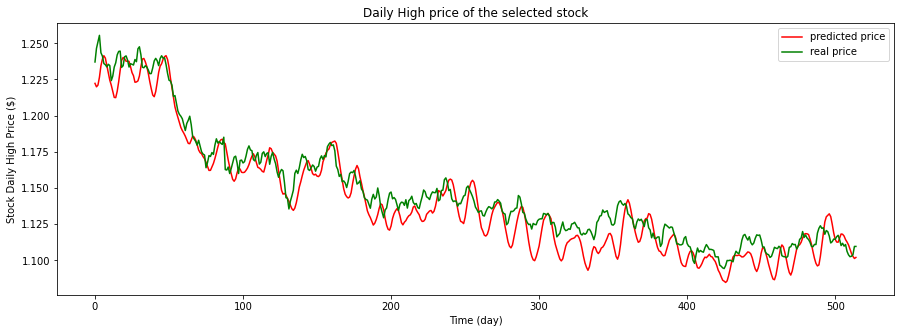

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,1.2371,1.222312,NaN,NaN
1,1.2465,1.219922,1.222312,-0.002390
2,1.2510,1.221135,1.219922,0.001213
3,1.2555,1.226537,1.221135,0.005401
4,1.2435,1.234398,1.226537,0.007862
...,...,...,...,...
510,1.1025,1.107736,1.110697,-0.002962
511,1.1028,1.104761,1.107736,-0.002974
512,1.1039,1.102734,1.104761,-0.002027
513,1.1096,1.101271,1.102734,-0.001462


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,1.2371,1.222312,NaN,NaN,NaN,1.234000,NaN
1,1.2465,1.219922,1.222312,-0.002390,-0.383538,1.241075,0.005733
2,1.2510,1.221135,1.219922,0.001213,0.193994,1.249250,0.006587
3,1.2555,1.226537,1.221135,0.005401,0.860436,1.244125,-0.004102
4,1.2435,1.234398,1.226537,0.007862,1.264429,1.240450,-0.002954
5,1.2412,1.239071,1.234398,0.004673,0.752979,1.235150,-0.004273
6,1.2360,1.241409,1.239071,0.002338,0.378263,1.230225,-0.003987
7,1.2352,1.239765,1.241409,-0.001644,-0.266263,1.231800,0.001280
8,1.2337,1.234563,1.239765,-0.005202,-0.843328,1.230225,-0.001279
9,1.2355,1.229689,1.234563,-0.004874,-0.788941,1.231675,0.001179


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

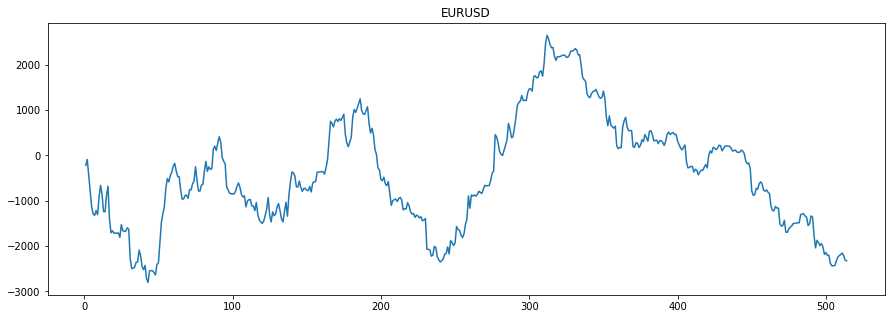

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.title(currency_name)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

-0.43334610480543484

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.023715415019763

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 3598.2686619663104 , from day 186 , to day 240
